# PS reconstruction, non-Gaussian beam, t scan study

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quadlet_tdc_bend
from phase_space_reconstruction.virtual.scans import run_3d_scan, run_t_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.visualization import plot_3d_scan_data
from phase_space_reconstruction.train import train_3d_scan, train_3d_scan_parallel_gpus

from bmadx.distgen_utils import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

## Create synthetic ground truth beam

In [2]:
# create synthetic ground truth beam from base and transform yaml files
yaml_dir = os.path.join('data', 'yaml_files')
p0c = 43.36e6 # reference momentum in eV/c
gt_beam_low_E = create_beam(
    base_yaml = os.path.join(yaml_dir, 'gaussian.yaml'),
    transforms_yaml = os.path.join(yaml_dir, 'transforms-linear-no-z-E-corr.yaml'), 
    p0c = p0c,
    n_particle = 1_000_000,
)

gt_beam_normal = create_beam(
    base_yaml = os.path.join(yaml_dir, 'gaussian.yaml'),
    transforms_yaml = os.path.join(yaml_dir, 'transforms-linear.yaml'), 
    p0c = p0c,
    n_particle = 1_000_000,
)

In [3]:
from stats import *
from scipy.ndimage import gaussian_filter
from scipy.signal import medfilt


def get_coord_unit_and_label(name, scale, use_pz_percentage_units=True):
    SPACE_COORDS = ("x", "y", "z")
    MOMENTUM_COORDS = ("px", "py", "pz")
    
    if name in SPACE_COORDS and scale == 1e3:
        unit = "mm"
    elif name in SPACE_COORDS and scale == 1:
        unit = "m"
    elif name in MOMENTUM_COORDS and scale == 1e3:
        unit = "mrad"
    elif name in MOMENTUM_COORDS and scale == 1:
        unit = "rad"
    else:
        raise ValueError(
            """scales should be 1 or 1e3,
        coords should be a subset of ('x', 'px', 'y', 'py', 'z', 'pz')
        """
        )

    if name == "pz" and use_pz_percentage_units:
        unit = "%"

    l = name
    if "p" in name:
        l = f"$p_{name[-1]}$"
        
    return unit, l
    

def plot_single_projection_with_contours(
    reconstruction, x_coord:str, y_coord:str, 
    ground_truth=None, 
    hist_range=None, 
    n_bins=20,
    contour_percentiles=[50,90],
    ax=None,
    background=0,
    contour_smoothing=0.0,
    median_filter_size=5,
    use_pz_percentage_units=True,

):
    n_contours = len(contour_percentiles)

    COLORS = ["white", "gray", "black"]
    COLORS = COLORS * (n_contours // int(len(COLORS) + 0.1) + 1)
    if ax is None:
        fig,ax = plt.subplots()
        
    
    xunit, xlabel = get_coord_unit_and_label(x_coord, 1e3,use_pz_percentage_units)
    yunit, ylabel = get_coord_unit_and_label(y_coord, 1e3,use_pz_percentage_units)
    
    # scale beam distribution to correct units
    scale_dict = {ele: 1e3 for ele in ("x", "px", "y", "py", "z", "pz")}
    if use_pz_percentage_units:
        scale_dict["pz"] = 1e2

    reconstruction = scale_beam_coords(reconstruction, scale_dict)
    if ground_truth is not None:
        ground_truth = scale_beam_coords(ground_truth, scale_dict)

    ax.set_xlabel(f"{xlabel} ({xunit})")
    ax.set_ylabel(f"{ylabel} ({yunit})")

    x_array = getattr(reconstruction, x_coord)
    y_array = getattr(reconstruction, y_coord)

    hist, x_edges, y_edges, _ = ax.hist2d(
                x_array,
                y_array,
                bins=int(n_bins),
                range=hist_range,
                vmin=background,
                rasterized=True,
    )

    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2

    for k, percentile in enumerate(contour_percentiles):
        h_r_fractions = get_beam_fraction_hist2d(hist, percentile / 100)
        ax.contour(
            x_centers,
            y_centers,
            medfilt(
                gaussian_filter(h_r_fractions, contour_smoothing),
                median_filter_size,
            ).T,
            # h_r_fractions.T,
            levels=[1],
            linestyles="--",
            colors=COLORS[k],
            linewidths=1,
            zorder=10,
            )

        if ground_truth is not None:
            h_gt, _, _ = np.histogram2d(
                getattr(ground_truth, x_coord),
                getattr(ground_truth, y_coord),
                bins=int(n_bins),
                range=hist_range,
            )
            h_gt_fractions = get_beam_fraction_hist2d(h_gt, percentile / 100)

            ax.contour(
                x_centers,
                y_centers,
                medfilt(
                    gaussian_filter(h_gt_fractions, contour_smoothing),
                    median_filter_size,
                ).T,
                # h_gt_fractions.T,
                levels=[1],
                linestyles="-",
                colors=COLORS[k],
                linewidths=1,
                )

    ax.set_xlim(*hist_range[0])
    ax.set_ylim(*hist_range[1])
    
    return ax


def plot_projections_with_contours(
    reconstruction,
    ground_truth=None,
    contour_percentiles=[50, 95],
    contour_smoothing=0.0,
    coords=("x", "px", "y", "py", "z", "pz"),
    n_bins=200,
    background=0,
    same_lims=False,
    custom_lims=None,
    use_pz_percentage_units=True,
    median_filter_size=5,
):

    # set up plot objects
    n_coords = len(coords)

    fig_size = (n_coords * 2,) * 2

    fig, ax = plt.subplots(
        n_coords, n_coords, figsize=fig_size, dpi=300, sharex="col",
        gridspec_kw={"left":0.1,"bottom":0.075,"top":0.975}
    )

    all_coords = []

    for coord in coords:
        all_coords.append(getattr(reconstruction, coord))

    all_coords = np.array(all_coords)

    if same_lims:
        if custom_lims is None:
            coord_min = np.ones(n_coords) * all_coords.min()
            coord_max = np.ones(n_coords) * all_coords.max()
        elif len(custom_lims) == 2:
            coord_min = np.ones(n_coords) * custom_lims[0]
            coord_max = np.ones(n_coords) * custom_lims[1]
        else:
            raise ValueError("custom lims should have shape 2 when same_lims=True")
    else:
        if custom_lims is None:
            coord_min = all_coords.min(axis=1)
            coord_max = all_coords.max(axis=1)
        elif custom_lims.shape == (n_coords, 2):
            coord_min = custom_lims[:, 0]
            coord_max = custom_lims[:, 1]
        else:
            raise ValueError(
                "custom lims should have shape (n_coords x 2) when same_lims=False"
            )

    for i in range(n_coords):
        x_coord = coords[i]
        min_x = coord_min[i]
        max_x = coord_max[i]
        x_array = getattr(reconstruction, x_coord)

        scale = 1e2 if x_coord=="pz" else 1e3
        h, bins = np.histogram(
            x_array*scale,
            range=(float(min_x), float(max_x)),
            bins=int(n_bins),
            density=True,
        )
        binc = (bins[:-1] + bins[1:]) / 2

        ax[i, i].plot(binc, h, "C1--", alpha=1, lw=2, zorder=5)
        ax[i, i].set_ylim(0, 1.1 * np.max(h))

        if ground_truth is not None:
            h, bins = np.histogram(
                getattr(ground_truth, x_coord)*scale,
                range=(float(min_x), float(max_x)),
                bins=int(n_bins),
                density=True,
            )

            binc = (bins[:-1] + bins[1:]) / 2
            ax[i, i].plot(binc, h, "C0-", alpha=1, lw=2)

        ax[i, i].yaxis.set_tick_params(left=False, labelleft=False)

        if i != n_coords - 1:
            ax[i, i].xaxis.set_tick_params(labelbottom=False)

        for j in range(i + 1, n_coords):
            min_y = coord_min[j]
            max_y = coord_max[j]
            hist_range = [[min_x, max_x], [min_y, max_y]]
            plot_single_projection_with_contours(
                reconstruction,
                coords[i],
                coords[j],
                ground_truth=ground_truth, 
                hist_range=hist_range, 
                n_bins=n_bins,
                contour_percentiles=contour_percentiles,
                ax=ax[j,i],
                background=background,
                contour_smoothing=contour_smoothing,
                median_filter_size=median_filter_size,
                use_pz_percentage_units=use_pz_percentage_units,
            )
            
            
            ax[i, j].set_visible(False)

            if i != 0:
                ax[j, i].yaxis.set_tick_params(labelleft=False)
                ax[j, i].set_ylabel(None)

            if j != n_coords - 1:
                ax[j, i].xaxis.set_tick_params(labelbottom=False)
                ax[j, i].set_xlabel(None)
        # ax[i,i].set_xlim(min_x, max_x)

    #fig.tight_layout()

    return fig, ax

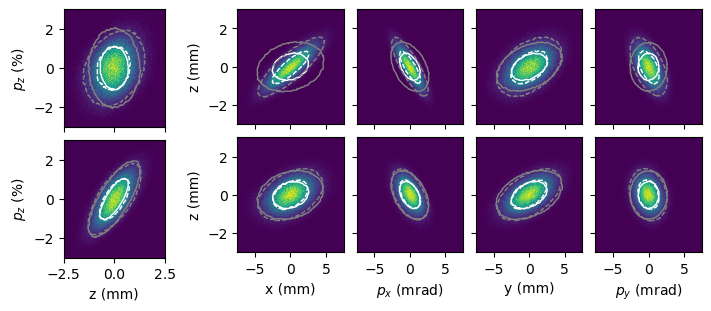

In [5]:
fig = plt.figure(layout='constrained', figsize=(7, 3))
subfigs = fig.subfigures(1, 2, wspace=0.01,width_ratios=[1, 3])



coords = ["x","px","y","py"]

gridspec_kw={"hspace":0.05,"top":0.975,"bottom":0.15}
transverse_axes = subfigs[1].subplots(2,len(coords),sharey=True,sharex=True,gridspec_kw=gridspec_kw)
longitudinal_axes = subfigs[0].subplots(2,1,sharey=True,sharex=True,gridspec_kw=gridspec_kw)

transverse_hist_range=[[-7.5,7.5],[-3,3]]
longitudinal_hist_range=[[-2.5,2.5],[-3,3]]

save_dir_low_E_t_scan = os.path.join('data', 'gaussian_beam', 'low_E_spread_t_scan')
save_dir_t_scan = os.path.join('data', 'gaussian_beam', 't_scan')

recn_dist_t_scan_low_E = torch.load(os.path.join(save_dir_low_E_t_scan, 'dist_3000.pt'))
recn_dist_t_scan_normal = torch.load(os.path.join(save_dir_t_scan, 'dist_3000.pt'))

beams = [
    [gt_beam_low_E, recn_dist_t_scan_low_E],
    [gt_beam_normal, recn_dist_t_scan_normal]
]
for j, beam in enumerate(beams):
    ax = plot_single_projection_with_contours(
            beam[1], 
            x_coord="z", 
            y_coord="pz", 
            hist_range=longitudinal_hist_range,
            ground_truth=beam[0], 
            n_bins=200,
            ax=longitudinal_axes[j]
        )
    if j==0:
        ax.set_xlabel("")

    for i, ele in enumerate(coords):
        ax = plot_single_projection_with_contours(
            beam[1], 
            x_coord=ele, 
            y_coord="z", 
            hist_range=transverse_hist_range,
            ground_truth=beam[0], 
            n_bins=200,
            ax=transverse_axes[j][i]
        )
        if j==0:
            ax.set_xlabel("")
        if i>0:
            ax.set_ylabel("")
#fig.savefig("t_scan_comparison.png",dpi=300)
#fig.savefig("t_scan_comparison.svg")
